从回归到分类:
回归:预测, 单连续数值输出, 跟真实值的区别作为损失
分类:多个值输出, 输出i为预测为第i类的可信度
何为Softmax回归:
1.一个多类分类模型
2.使用Softmax操作子, 得到每个类的预测置信度
3.使用交叉熵来衡量预测和标号的区别

损失函数:描述预测值和真实值之间的区别的函数
1.均方损失:梯度为一次函数, 距离0较远时,按梯度逼近可能过大
2.绝对值损失:不论如何梯度都是1
3.鲁棒损失:结合了1, 2;距离较远时按1逼进, 1以内时按一次函数逼近

In [7]:
#为了后面softmax算法的实现, 我们先学习如何导入图像分类数据集
%matplotlib inline
import torch
import torchvision #pytorch对于计算机视觉模型的实现的库
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [8]:
# 获取图像数据集, 放入内存
trans = transforms.ToTensor() # 将图像转为tensor的设置
# 拿到FashionMNIST并设置: 位置, 下载训练数据集, 转换为tensor
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True,
                                                transform=trans,
                                                download=True)
#下载测试数据集
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False,
                                               transform=trans, download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

In [9]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

 #画图函数
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

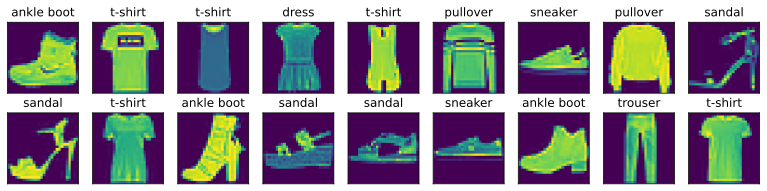

In [10]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [11]:
batch_size = 256

def get_dataloader_workers():
    """读取数据并不容易, 设定使用4个进程来读取数据。"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

# 读一次数据的时间
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'7.74 sec'

In [12]:
# 整合一下之前所有的函数
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


iter是什么:
与直接加载全部数据到内存的列表不同，迭代器采用"按需加载"机制。在你的代码中，DataLoader并不会一次性加载6万张Fashion-MNIST图片到内存，而是分批次生成数据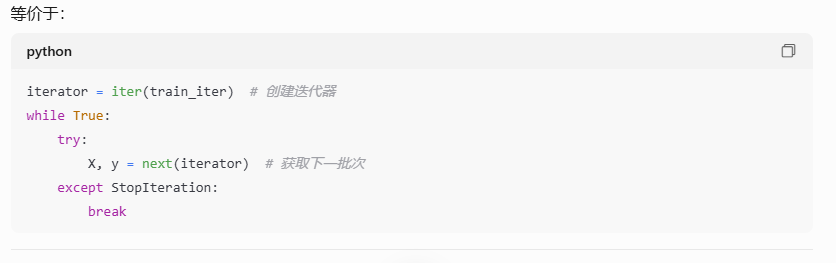

在从零开始实现softmax之前, 我们不妨回忆一下之前的从零开始都需要准备什么东西:
1.w, b的定义和处理
2.模型公式
线性变化得到信心得分
在利用softmax将每个类别的得分进行转换, 变为和为1的概率
3.损失函数
交叉熵
4.训练函数

In [13]:
# softmax的从零开始实现
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [14]:
# 对于一个图像, 将其展平后视为长度784的向量. 由于数据有十种类别, 设置10个输出维度
num_inputs = 784
num_outputs = 10

# w权重: 784x10矩阵，代表每个像素特征对10个类别的贡献度
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
# b偏差: 长度为10的向量，每个类别的基础得分
b = torch.zeros(num_outputs, requires_grad=True)

In [15]:
# softmax模型的实现
# 根据softmax的数学公式, 将线性输出转化为了总和为1的概率分布
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

# 原始图像 → 展平 → 线性变换, 每个样本加权计算 → Softmax概率转换 → 概率分布(28x28)  → 784维 → 10个得分 → 10个概率
# X 是输入特征（展平后的图像）。W(j是第 j 个类别的权重向量。点积 X⋅W(j 表示输入特征与第 j 个类别权重的匹配程度
# 所以线性变换后得到了信心得分, 在经过softmax算法, 就得到了概率
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

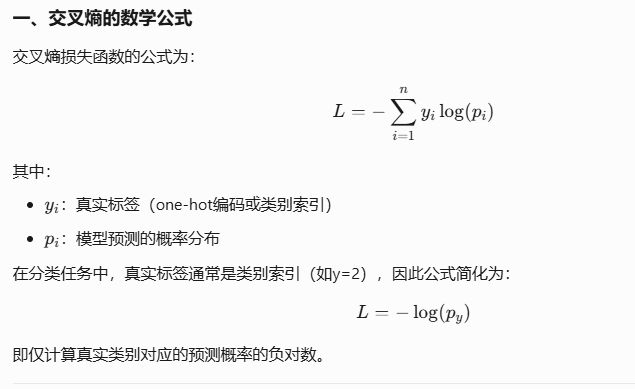

In [17]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]
# 交叉熵损失的实现
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

训练工具:
​Accumulator类
记录训练过程中的损失/准确率等指标
add()方法累加多个指标，reset()清零状态

​Animator类
动态绘制训练曲线（损失、准确率变化）
使用d2l库的绘图工具，实时更新可视化结果

In [18]:
def accuracy(y_hat, y):
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [19]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [20]:
# Accumulator 实例中创建了 2 个变量，用于分别存储正确预测的数量和预测的总数量
class Accumulator:
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）。"""
     # 1. 模型设置, 设置为训练模式（启用Dropout/BatchNorm等）
    if isinstance(net, torch.nn.Module):
        net.train()
    # 2. 初始化指标累加器, 用于存储: 总损失、正确预测数、总样本数
    metric = Accumulator(3)

    # 3. 遍历训练数据, 可以看到我们利用了迭代器
    for X, y in train_iter:
        # 4. 前向传播, 利用我们之前写好的net函数计算了y的预测值y_hat
        y_hat = net(X)
        # 5. 计算此批次的损失
        l = loss(y_hat, y)

        # 6. 反向传播与参数更新
        if isinstance(updater, torch.optim.Optimizer): # 如果使用了PyTorch内置优化器

            updater.zero_grad() # 清空梯度（避免累积）
            l.backward()  # 自动计算梯度
            updater.step() # 更新参数（比如上一章的SGD: W = W - lr * grad）
            # 记录指标（损失 × 样本数，正确数，样本数）
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel())
        else: # 自定义优化器（如从零实现的SGD）

            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [22]:
class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [23]:
# 初始化可视化工具,
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [24]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

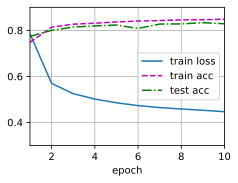

In [25]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

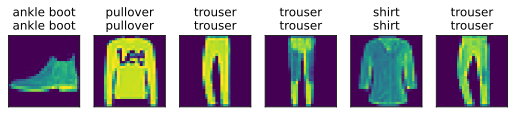

In [ ]:
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

In [ ]:
import torch
from torch import nn # 引入nn 用于简洁实现
from d2l import torch as d2l

# 设置batch_size, 数据载入迭代器中
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [ ]:
# nn.Flatten()**：将输入的二维图像（形状为[batch, 1, 28, 28]）展平为一维向量（[batch, 784]），以便输入全连接层
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

# 通过递归遍历网络层 + 条件判断，对线性层的权重进行小标准差正态分布初始化:
# 接收一个神经网络层 m
def init_weights(m):
        # 仅对线性层（全连接层）执行初始化，其他层不处理。
    if type(m) == nn.Linear:
        # ​功能：用正态分布（高斯分布）初始化权重张量。
            # m.weight：线性层的权重参数，形状为[out_features, in_features]。
            # std=0.01：标准差设为0.01，均值默认为0。
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

In [ ]:
# 定义交叉熵损失函数
loss = nn.CrossEntropyLoss()
# 配置随机梯度下降优化器
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [ ]:
# 执行模型训练与验证。
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)